# Two-Body Orbital Trajectory Simulator

Import Libraries

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib import animation

Initialize objects

In [4]:
# Constants
mu = 398600.0  # Earth's gravitational parameter (km^3/s^2)

# Two-body equations of motion
def two_body_equations(t, y):
    r = y[:3]
    v = y[3:]
    norm_r = np.linalg.norm(r)
    a = -mu * r / norm_r**3
    return np.concatenate((v, a))

In [6]:
# More eccentric orbit 
                #x, y, z
r0 = np.array([7000.0, 0.0, 4000.0]) #km (fixed)
v0 = np.array([0.0, 5.0, -5])  # Retrograde + inclined # Low inclination (flat in XY plane)
y0 = np.concatenate((r0, v0))


# Time settings
t_span = (0, 12000)  # seconds
t_eval = np.linspace(*t_span, 1500)

# Integrate orbit
sol = solve_ivp(two_body_equations, t_span, y0, t_eval=t_eval, rtol=1e-9, atol=1e-9)
x, y, z = sol.y[0], sol.y[1], sol.y[2]

Calculate Classical Orbital Elements (COE)

In [7]:
# === Orbital Elements ===
r_vec = r0
v_vec = v0
r = np.linalg.norm(r_vec)
v = np.linalg.norm(v_vec)
h_vec = np.cross(r_vec, v_vec)
h = np.linalg.norm(h_vec)
e_vec = (np.cross(v_vec, h_vec) / mu) - (r_vec / r)
e = np.linalg.norm(e_vec)
energy = v**2 / 2 - mu / r
a = -mu / (2 * energy)
i = np.arccos(h_vec[2] / h)
K = np.array([0, 0, 1])
n_vec = np.cross(K, h_vec)
n = np.linalg.norm(n_vec)
Omega = np.arccos(n_vec[0] / n) if n != 0 else 0
if n_vec[1] < 0:
    Omega = 2*np.pi - Omega
omega = np.arccos(np.dot(n_vec, e_vec) / (n * e)) if n != 0 and e != 0 else 0
if e_vec[2] < 0:
    omega = 2*np.pi - omega
nu = np.arccos(np.dot(e_vec, r_vec) / (e * r)) if e != 0 else 0
if np.dot(r_vec, v_vec) < 0:
    nu = 2*np.pi - nu

# Convert radians to degrees
i_deg = np.degrees(i)
Omega_deg = np.degrees(Omega)
omega_deg = np.degrees(omega)
nu_deg = np.degrees(nu)

# Print orbital elements
print("\nClassical Orbital Elements (COEs):")
print(f"Semi-major axis (a):       {a:.2f} km")
print(f"Eccentricity (e):          {e:.4f}")
print(f"Inclination (i):           {i_deg:.2f} deg")
print(f"RAAN (Ω):                  {Omega_deg:.2f} deg")
print(f"Argument of Periapsis (ω): {omega_deg:.2f} deg")
print(f"True Anomaly (ν):          {nu_deg:.2f} deg")


Classical Orbital Elements (COEs):
Semi-major axis (a):       8154.58 km
Eccentricity (e):          0.3510
Inclination (i):           49.03 deg
RAAN (Ω):                  209.74 deg
Argument of Periapsis (ω): 247.73 deg
True Anomaly (ν):          251.19 deg


Calculate foci points

In [8]:

# === Foci and Ellipse Center ===
c = a * e
e_hat = e_vec / np.linalg.norm(e_vec)
focus1 = np.array([0.0, 0.0, 0.0])           # Earth at origin
focus2 = e_hat * 2 * c                       # Second focus

Plot orbit animation

*will not show full animation in jupyter notebook*

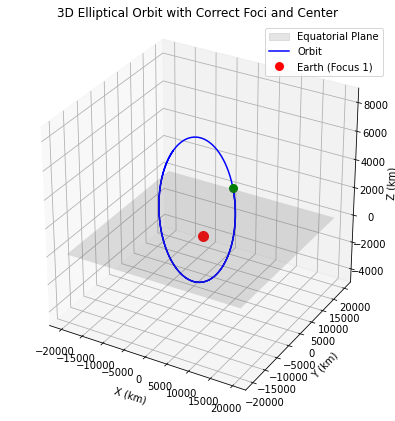

In [12]:

# === 3D Plotting and Animation ===
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Orbit path and markers
ax.plot(x, y, z, color='blue', label='Orbit')
ax.scatter(*focus1, color='red', s=100, label='Earth (Focus 1)')
#ax.scatter(*focus2, color='purple', s=60, label='Second Focus')
#ax.scatter(*center, color='black', s=40, label='Ellipse Center')

# Equatorial plane
plane_size = 20000
X, Y = np.meshgrid(np.linspace(-plane_size, plane_size, 2),
                   np.linspace(-plane_size, plane_size, 2))
Z = np.zeros_like(X)
ax.plot_surface(X, Y, Z, color='gray', alpha=0.2)

# Satellite marker
satellite, = ax.plot([], [], [], 'o', color='green', markersize=8)

# Legend with proxies
legend_elements = [
    Patch(facecolor='gray', edgecolor='gray', label='Equatorial Plane', alpha=0.2),
    plt.Line2D([0], [0], color='blue', label='Orbit'),
    plt.Line2D([0], [0], marker='o', color='w', label='Earth (Focus 1)', markerfacecolor='red', markersize=10),
    #plt.Line2D([0], [0], marker='o', color='w', label='Second Focus', markerfacecolor='purple', markersize=8),
]
ax.legend(handles=legend_elements)

# Formatting
ax.set_box_aspect([1, 1, 1])
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.set_title("3D Elliptical Orbit with Correct Foci and Center")

# Animation update
def update(frame):
    satellite.set_data([x[frame]], [y[frame]])
    satellite.set_3d_properties([z[frame]])
    return satellite,

ani = animation.FuncAnimation(fig, update, frames=len(x), interval=20, blit=True)

plt.show()